In [205]:
from datetime import datetime
import json
from collections import Counter

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, Dataset
import torchmetrics

from deeprec.torch.trainer import Trainer, set_device
from deeprec import ROOT

In [206]:
with open('../data/metadata.json', 'r') as fp:
    meta = json.load(fp)

meta.keys()

dict_keys(['title_emb_size', 'string_na', 'genres', 'ages', 'occupations', 'user', 'movie', 'city', 'state'])

In [207]:
len(Counter([2, 1, 3]))


class Vocab(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, x):
        c = Counter(x)
        self.lookup_ = {
            str(v).lower(): k for k, v in enumerate([x[0] for x in sorted(c.items(), key=lambda x: x[1], reverse=True)])
        }

    def transform(self, x):
        return [self.lookup_.get(str(xx).lower(), len(self.lookup_) + 1) for xx in x]

In [208]:
state_enc = Vocab()
state_enc.fit(meta['state'])

city_enc = Vocab()
city_enc.fit(meta['city'])

In [209]:
df = pd.read_parquet('../data/train.parq.gzip').drop('rating', axis=1)
df.head()

,user,movie,hour,day_of_week,month,ts,gender,age,occupation,city,...,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20,embed_21,embed_22,embed_23,embed_24
index,,,,,,,,,,,,,,,,,,,,,
693094,1489,2648,3,5,11,2000-11-25 03:35:14,1,35,2,Evanston,...,0.059832,0.46583,0.774960,0.43321,0.370830,0.140020,0.521110,-0.960430,-0.622770,0.245130
563664,2440,3101,17,1,11,2000-11-14 17:03:49,0,50,17,Ashburnham,...,1.982520,0.84989,1.708770,1.34452,-1.051670,-0.032240,0.662540,-0.448420,-1.197040,-0.698660
192,682,1193,16,3,11,2000-11-30 16:33:10,0,25,4,Carrboro,...,2.176160,2.86298,2.238394,-2.15952,1.210480,-3.436165,-0.329595,3.619880,-2.470530,1.399963
664671,3512,1005,17,0,8,2000-08-28 17:16:19,0,18,17,Cambridge,...,-1.662040,0.99335,-1.184181,1.58626,0.718946,-1.731300,2.357530,1.096584,-2.896070,0.150750
967203,5074,1202,5,5,7,2000-07-01 05:14:36,0,1,0,Purcellville,...,1.998510,1.07155,-0.863230,0.24211,-0.773756,0.235041,1.170840,-2.078201,-1.310696,-0.964250


In [210]:
df = pd.read_parquet('../data/train.parq.gzip', columns=['rating'])
df.head()

,rating
index,
693094,3
563664,4
192,5
664671,3
967203,5


In [211]:
set(df['rating'])

{1, 2, 3, 4, 5}

In [214]:
class MovieDataset(Dataset):
    def __init__(self, filename, state_vocab, city_vocab):
        drop_cols = ['rating', 'ts']
        x = pd.read_parquet(filename).drop(drop_cols, axis=1)
        y = pd.read_parquet(filename, columns=['rating'])

        x['state'] = state_vocab.transform(x['state'])
        x['city'] = city_vocab.transform(x['city'])

        self.feature_names = x.columns
        self.x = torch.tensor(x.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [215]:
train = MovieDataset('../data/train.parq.gzip', state_vocab=state_enc, city_vocab=city_enc)
test = MovieDataset('../data/test.parq.gzip', state_vocab=state_enc, city_vocab=city_enc)

In [216]:
print(len(train.feature_names))
train.feature_names

54


Index(['user', 'movie', 'hour', 'day_of_week', 'month', 'gender', 'age',
       'occupation', 'city', 'state', 'year', 'genre_action',
       'genre_adventure', 'genre_animation', 'genre_childrens', 'genre_comedy',
       'genre_crime', 'genre_documentary', 'genre_drama', 'genre_fantasy',
       'genre_filmnoir', 'genre_horror', 'genre_musical', 'genre_mystery',
       'genre_romance', 'genre_scifi', 'genre_thriller', 'genre_war',
       'genre_western', 'embed_0', 'embed_1', 'embed_2', 'embed_3', 'embed_4',
       'embed_5', 'embed_6', 'embed_7', 'embed_8', 'embed_9', 'embed_10',
       'embed_11', 'embed_12', 'embed_13', 'embed_14', 'embed_15', 'embed_16',
       'embed_17', 'embed_18', 'embed_19', 'embed_20', 'embed_21', 'embed_22',
       'embed_23', 'embed_24'],
      dtype='object')

In [217]:
next(iter(train))

(tensor([ 1.4890e+03,  2.6480e+03,  3.0000e+00,  5.0000e+00,  1.1000e+01,
          1.0000e+00,  3.5000e+01,  2.0000e+00,  4.5000e+01,  3.0000e+00,
          1.9310e+03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -6.4381e-01,
         -1.7824e-01,  9.7300e-01,  6.9695e-01, -2.1724e-01, -7.9311e-01,
          2.6056e-01, -5.3553e-01,  3.1386e-01, -1.3234e+00,  2.8217e-01,
          3.6116e-01, -1.3419e+00, -7.3678e-01,  8.2521e-01,  5.9832e-02,
          4.6583e-01,  7.7496e-01,  4.3321e-01,  3.7083e-01,  1.4002e-01,
          5.2111e-01, -9.6043e-01, -6.2277e-01,  2.4513e-01]),
 tensor([3.]))

In [218]:
embd = nn.Embedding(
    num_embeddings=len(meta['state'].keys())+ 1,
    embedding_dim=25
)

In [219]:
embd(torch.tensor([[9]]))

tensor([[[ 1.7129,  0.6487, -0.4383, -0.4675,  0.8777, -0.1852,  0.2573,
           0.1484, -1.8972,  0.5618,  0.3932, -0.3001, -0.4844, -2.5479,
           0.7714,  0.8212, -0.0270, -0.3300,  0.2350,  0.0611, -0.7802,
          -0.5662,  0.1482,  0.3999, -0.5894]]], grad_fn=<EmbeddingBackward0>)

In [220]:
class RecModel(nn.Module):
    def __init__(self, metadata, n_features=54):
        super().__init__()
        self.meta = metadata
        self.loss_func = nn.MSELoss()

        self.model = nn.Sequential(
            nn.Linear(in_features=n_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=1)
        )

    def forward(self, x):
        x = self.model(x)
        return x

    def predict(self, x):
        return self(x)

In [223]:
NOW = datetime.now().strftime('%Y%m%d-%H%M')
LOG_DIR = ROOT.joinpath('runs', NOW)
BATCH = 10_000

train_loader = DataLoader(train, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH)

device = set_device()
mod = RecModel(metadata=meta)
opt = torch.optim.AdamW(mod.parameters(), lr=0.01)
trainer = Trainer(
    mod, epochs=15, device=device, log_dir=LOG_DIR, checkpoint_file=LOG_DIR.joinpath('model.pt'),
    optimizer=opt, score_funcs={'mse': torchmetrics.MeanSquaredError()}
)
trainer.fit(train_loader, test_loader)

Batch: 100%|██████████| 91/91 [00:13<00:00,  8.67it/s]
                                                      
Batch:  99%|█████████▉| 90/91 [00:12<00:00,  6.60it/s]
                                                      
Batch:  99%|█████████▉| 90/91 [00:12<00:00,  5.43it/s]
                                                      
Batch: 100%|██████████| 91/91 [00:14<00:00,  4.93it/s]
                                                      
Batch:  99%|█████████▉| 90/91 [00:12<00:00,  9.37it/s]
                                                      
Batch: 100%|██████████| 91/91 [00:11<00:00, 10.71it/s]
                                                      
Batch: 100%|██████████| 91/91 [00:12<00:00, 10.41it/s]
                                                      
Batch:  99%|█████████▉| 90/91 [00:12<00:00,  7.79it/s]
                                                      
Batch:  99%|█████████▉| 90/91 [00:12<00:00,  8.03it/s]
                                                      
Batch:  99

In [224]:
{e:v for e,v in enumerate(torch.sqrt(torch.tensor(trainer.results['valid_mse'])))}

{0: tensor(1.1615),
 1: tensor(1.1422),
 2: tensor(1.1242),
 3: tensor(1.1534),
 4: tensor(1.1324),
 5: tensor(1.1176),
 6: tensor(1.1230),
 7: tensor(1.1312),
 8: tensor(1.1207),
 9: tensor(1.1192),
 10: tensor(1.1275),
 11: tensor(1.1187),
 12: tensor(1.1283),
 13: tensor(1.1119),
 14: tensor(1.1564)}

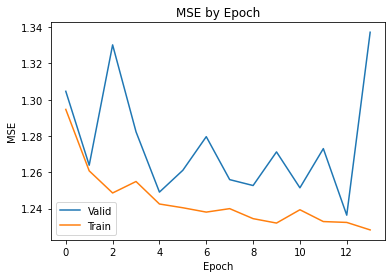

In [227]:
import matplotlib.pyplot as plt

plt.plot(trainer.results['valid_mse'][1:], label='Valid')
plt.plot(trainer.results['train_mse'][1:], label='Train')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('MSE by Epoch')
plt.show()